<a href="https://colab.research.google.com/github/Asoub2001/multi-class-tweet-classifier/blob/main/twitter_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
# Data manipulation & utilities
import pandas as pd
import numpy as np
import re
import time
import joblib
import os


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing & vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Dimensionality reduction
from sklearn.decomposition import PCA

# Train/test split
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# For baseline model
from sklearn.dummy import DummyClassifier

# For precision-recall curve (multi-class)
from sklearn.preprocessing import label_binarize

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay

)

# Label preprocessing for ROC/PR curves
from sklearn.preprocessing import label_binarize


In [110]:
# Load the Data
# Load the JSON dataset into a pandas DataFrame
data = pd.read_json('/content/CETM47_24_5-AS2-Data.json')

#  Preview the data before cleaning (display the first 5 rows)
print("Data Preview Before Cleaning:")
print(data[['text']].head())  # Show the first 5 tweets


Data Preview Before Cleaning:
                                                text
0  The {@Clinton LumberKings@} beat the {@Cedar R...
1  I would rather hear Eli Gold announce this Aub...
2  Someone take my phone away, I’m trying to not ...
3  A year ago, Louisville struggled to beat an FC...
4  Anyone know why the #Dodgers #Orioles game nex...


In [111]:
# Check for null values in the dataset
print(data.isnull().sum())


text          0
date          0
label         0
id            0
label_name    0
dtype: int64


In [112]:
# Check for duplicate rows
print(f"Number of duplicate rows: {data.duplicated().sum()}")


Number of duplicate rows: 0


In [113]:
# Data Preprocessing
# Function to clean the tweet text by removing URLs, user mentions, and special characters
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", '', text)

    # Keep mentions and hashtags (they carry meaning in tweets)
    text = re.sub(r"[^a-zA-Z0-9\s@#]", '', text)

    # Convert to lowercase and return
    return text.lower()



# Apply the cleaning function to the 'text' column and store the results in a new column
data['cleaned_text'] = data['text'].apply(clean_text)

# Preview the data after cleaning (display the first 5 rows)
print("\nData Preview After Cleaning:")
print(data[['text', 'cleaned_text']].head())  # Show original and cleaned tweets side by side


Data Preview After Cleaning:
                                                text  \
0  The {@Clinton LumberKings@} beat the {@Cedar R...   
1  I would rather hear Eli Gold announce this Aub...   
2  Someone take my phone away, I’m trying to not ...   
3  A year ago, Louisville struggled to beat an FC...   
4  Anyone know why the #Dodgers #Orioles game nex...   

                                        cleaned_text  
0  the @clinton lumberkings@ beat the @cedar rapi...  
1  i would rather hear eli gold announce this aub...  
2  someone take my phone away im trying to not lo...  
3  a year ago louisville struggled to beat an fcs...  
4  anyone know why the #dodgers #orioles game nex...  


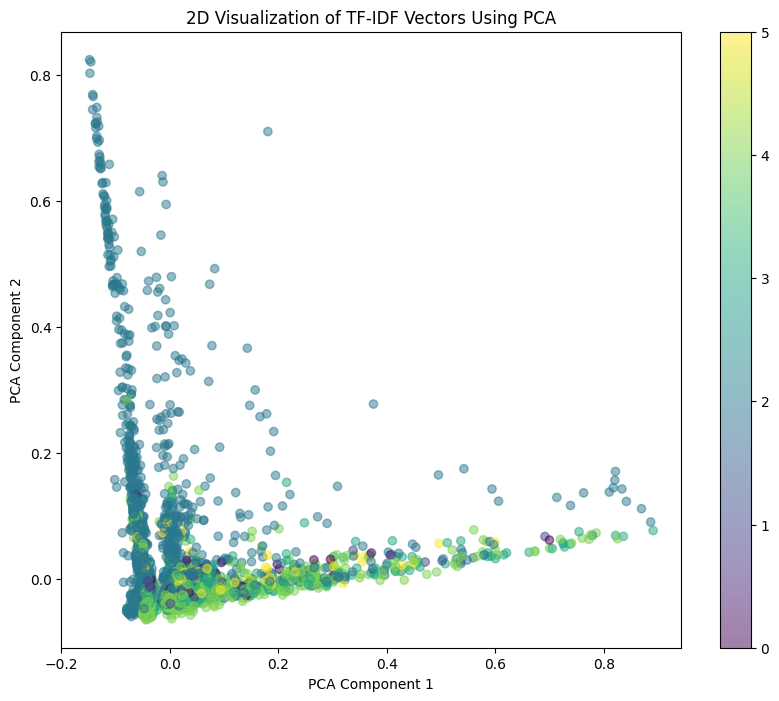

In [114]:

# Text Vectorization
# Convert the cleaned text into numerical representations using TF-IDF (Term Frequency-Inverse Document Frequency)
# TF-IDF helps represent the text as a sparse matrix of numeric features that can be used for machine learning
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_text'])  # Apply the vectorizer to the cleaned text

# Reduce dimensionality using PCA to 2 components
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
X_pca = pca.fit_transform(X.toarray())  # Perform PCA on the dense representation of TF-IDF

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=data['label'], cmap='viridis')  # Scatter plot
plt.colorbar()  # Add a color bar to indicate the labels
plt.title("2D Visualization of TF-IDF Vectors Using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [115]:
# Split the Data
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

In [116]:
from sklearn.dummy import DummyClassifier

# Create the baseline model (majority class strategy)
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)

# Predict on test set
baseline_preds = baseline_model.predict(X_test)

# Evaluate
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='macro')
baseline_precision = precision_score(y_test, baseline_preds, average='macro')
baseline_recall = recall_score(y_test, baseline_preds, average='macro')
baseline_acc_percent = baseline_acc * 100  # Convert to %


print("Baseline (Majority Class) Classifier Performance:")
print(f"Accuracy: {baseline_acc_percent:.2f}%")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1 Score: {baseline_f1:.4f}")


Baseline (Majority Class) Classifier Performance:
Accuracy: 38.56%
Precision: 0.0643
Recall: 0.1667
F1 Score: 0.0928


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [117]:
# === Naive Bayes Model ===

# Create and train the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)  # Train the model using the training data
nb_preds = nb_model.predict(X_test)  # Predict on the test data
nb_acc = accuracy_score(y_test, nb_predictions) * 100



In [118]:
# === Logistic Regression Model ===
# Create and train the Logistic Regression classifier with balanced class weights
lr_model = LogisticRegression(max_iter=200, class_weight='balanced')
lr_model.fit(X_train, y_train)  # Train the model
lr_preds = lr_model.predict(X_test)  # Predict on the test data
lr_acc = accuracy_score(y_test, lr_preds) * 100

In [119]:
# === Support Vector Machine (SVM) Model ===
# Create and train a linear SVM classifier with balanced class weights
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)  # Train the model
svm_preds = svm_model.predict(X_test)  # Predict on the test data
svm_acc = accuracy_score(y_test, svm_preds) * 100

In [120]:
# ----- Naive Bayes -----
nb_predictions = nb_model.predict(X_test)  # Predict using Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, nb_predictions))

Naive Bayes Accuracy: 0.747866563227308
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       1.00      0.08      0.15        60
           2       0.70      0.92      0.80       497
           3       0.77      0.30      0.43       179
           4       0.79      0.95      0.86       468
           5       0.71      0.08      0.15        60

    accuracy                           0.75      1289
   macro avg       0.66      0.39      0.40      1289
weighted avg       0.75      0.75      0.70      1289

Naive Bayes Confusion Matrix:
[[  0   0  19   2   4   0]
 [  0   5  25   9  20   1]
 [  0   0 455   2  39   1]
 [  0   0  89  54  36   0]
 [  0   0  23   0 445   0]
 [  0   0  35   3  17   5]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
# ----- Logistic Regression -----
lr_predictions = lr_model.predict(X_test)  # Predict using Logistic Regression model
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))


Logistic Regression Accuracy: 0.7944142746314973
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        25
           1       0.58      0.53      0.56        60
           2       0.91      0.77      0.84       497
           3       0.54      0.72      0.61       179
           4       0.89      0.91      0.90       468
           5       0.59      0.68      0.63        60

    accuracy                           0.79      1289
   macro avg       0.66      0.68      0.67      1289
weighted avg       0.81      0.79      0.80      1289

Logistic Regression Confusion Matrix:
[[ 12   1   4   6   1   1]
 [  0  32   3  14   7   4]
 [  1   2 385  65  29  15]
 [  5  13  15 129  12   5]
 [  4   4  13  18 425   4]
 [  3   3   2   9   2  41]]


In [122]:
# ----- Support Vector Machine (SVM) -----
svm_predictions = svm_model.predict(X_test)  # Predict using SVM model
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))

SVM Accuracy: 0.8238944918541505
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        25
           1       0.66      0.55      0.60        60
           2       0.87      0.84      0.86       497
           3       0.64      0.70      0.67       179
           4       0.89      0.93      0.91       468
           5       0.67      0.67      0.67        60

    accuracy                           0.82      1289
   macro avg       0.73      0.69      0.71      1289
weighted avg       0.82      0.82      0.82      1289

SVM Confusion Matrix:
[[ 12   0   4   5   3   1]
 [  0  33   5  11   8   3]
 [  1   3 418  34  30  11]
 [  2  10  29 125  10   3]
 [  0   2  17  13 434   2]
 [  3   2   5   7   3  40]]


Model Accuracies (%):
Naive Bayes: 74.79%
Logistic Regression: 79.44%
SVM: 82.39%


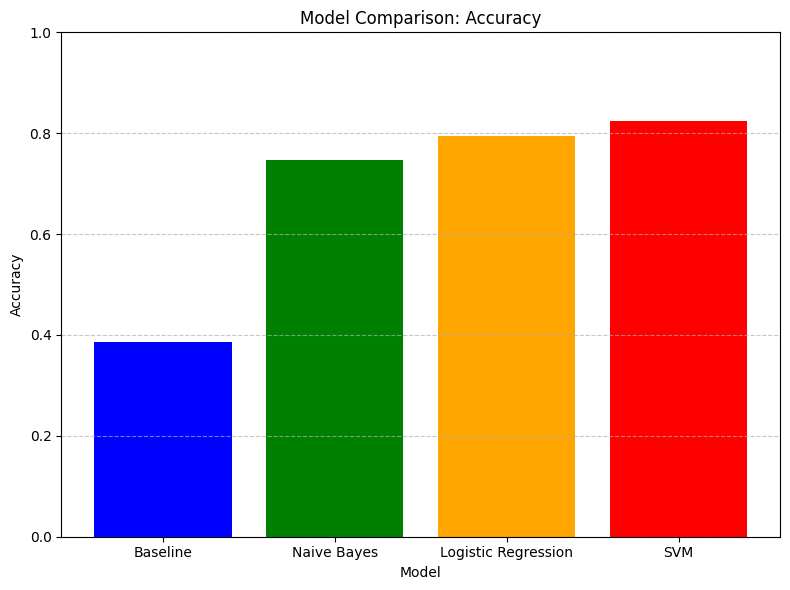

In [123]:
#show the accuracy as a percantage
print("Model Accuracies (%):")
print(f"Naive Bayes: {nb_acc:.2f}%")
print(f"Logistic Regression: {lr_acc:.2f}%")
print(f"SVM: {svm_acc:.2f}%")


# Model names and their accuracy scores
baseline_acc = accuracy_score(y_test, baseline_preds)

models = ['Baseline', 'Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [
    baseline_acc,
    accuracy_score(y_test, nb_predictions),
    accuracy_score(y_test, lr_predictions),
    accuracy_score(y_test, svm_predictions)
]



# Plotting the comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange','red'])
plt.title('Model Comparison: Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




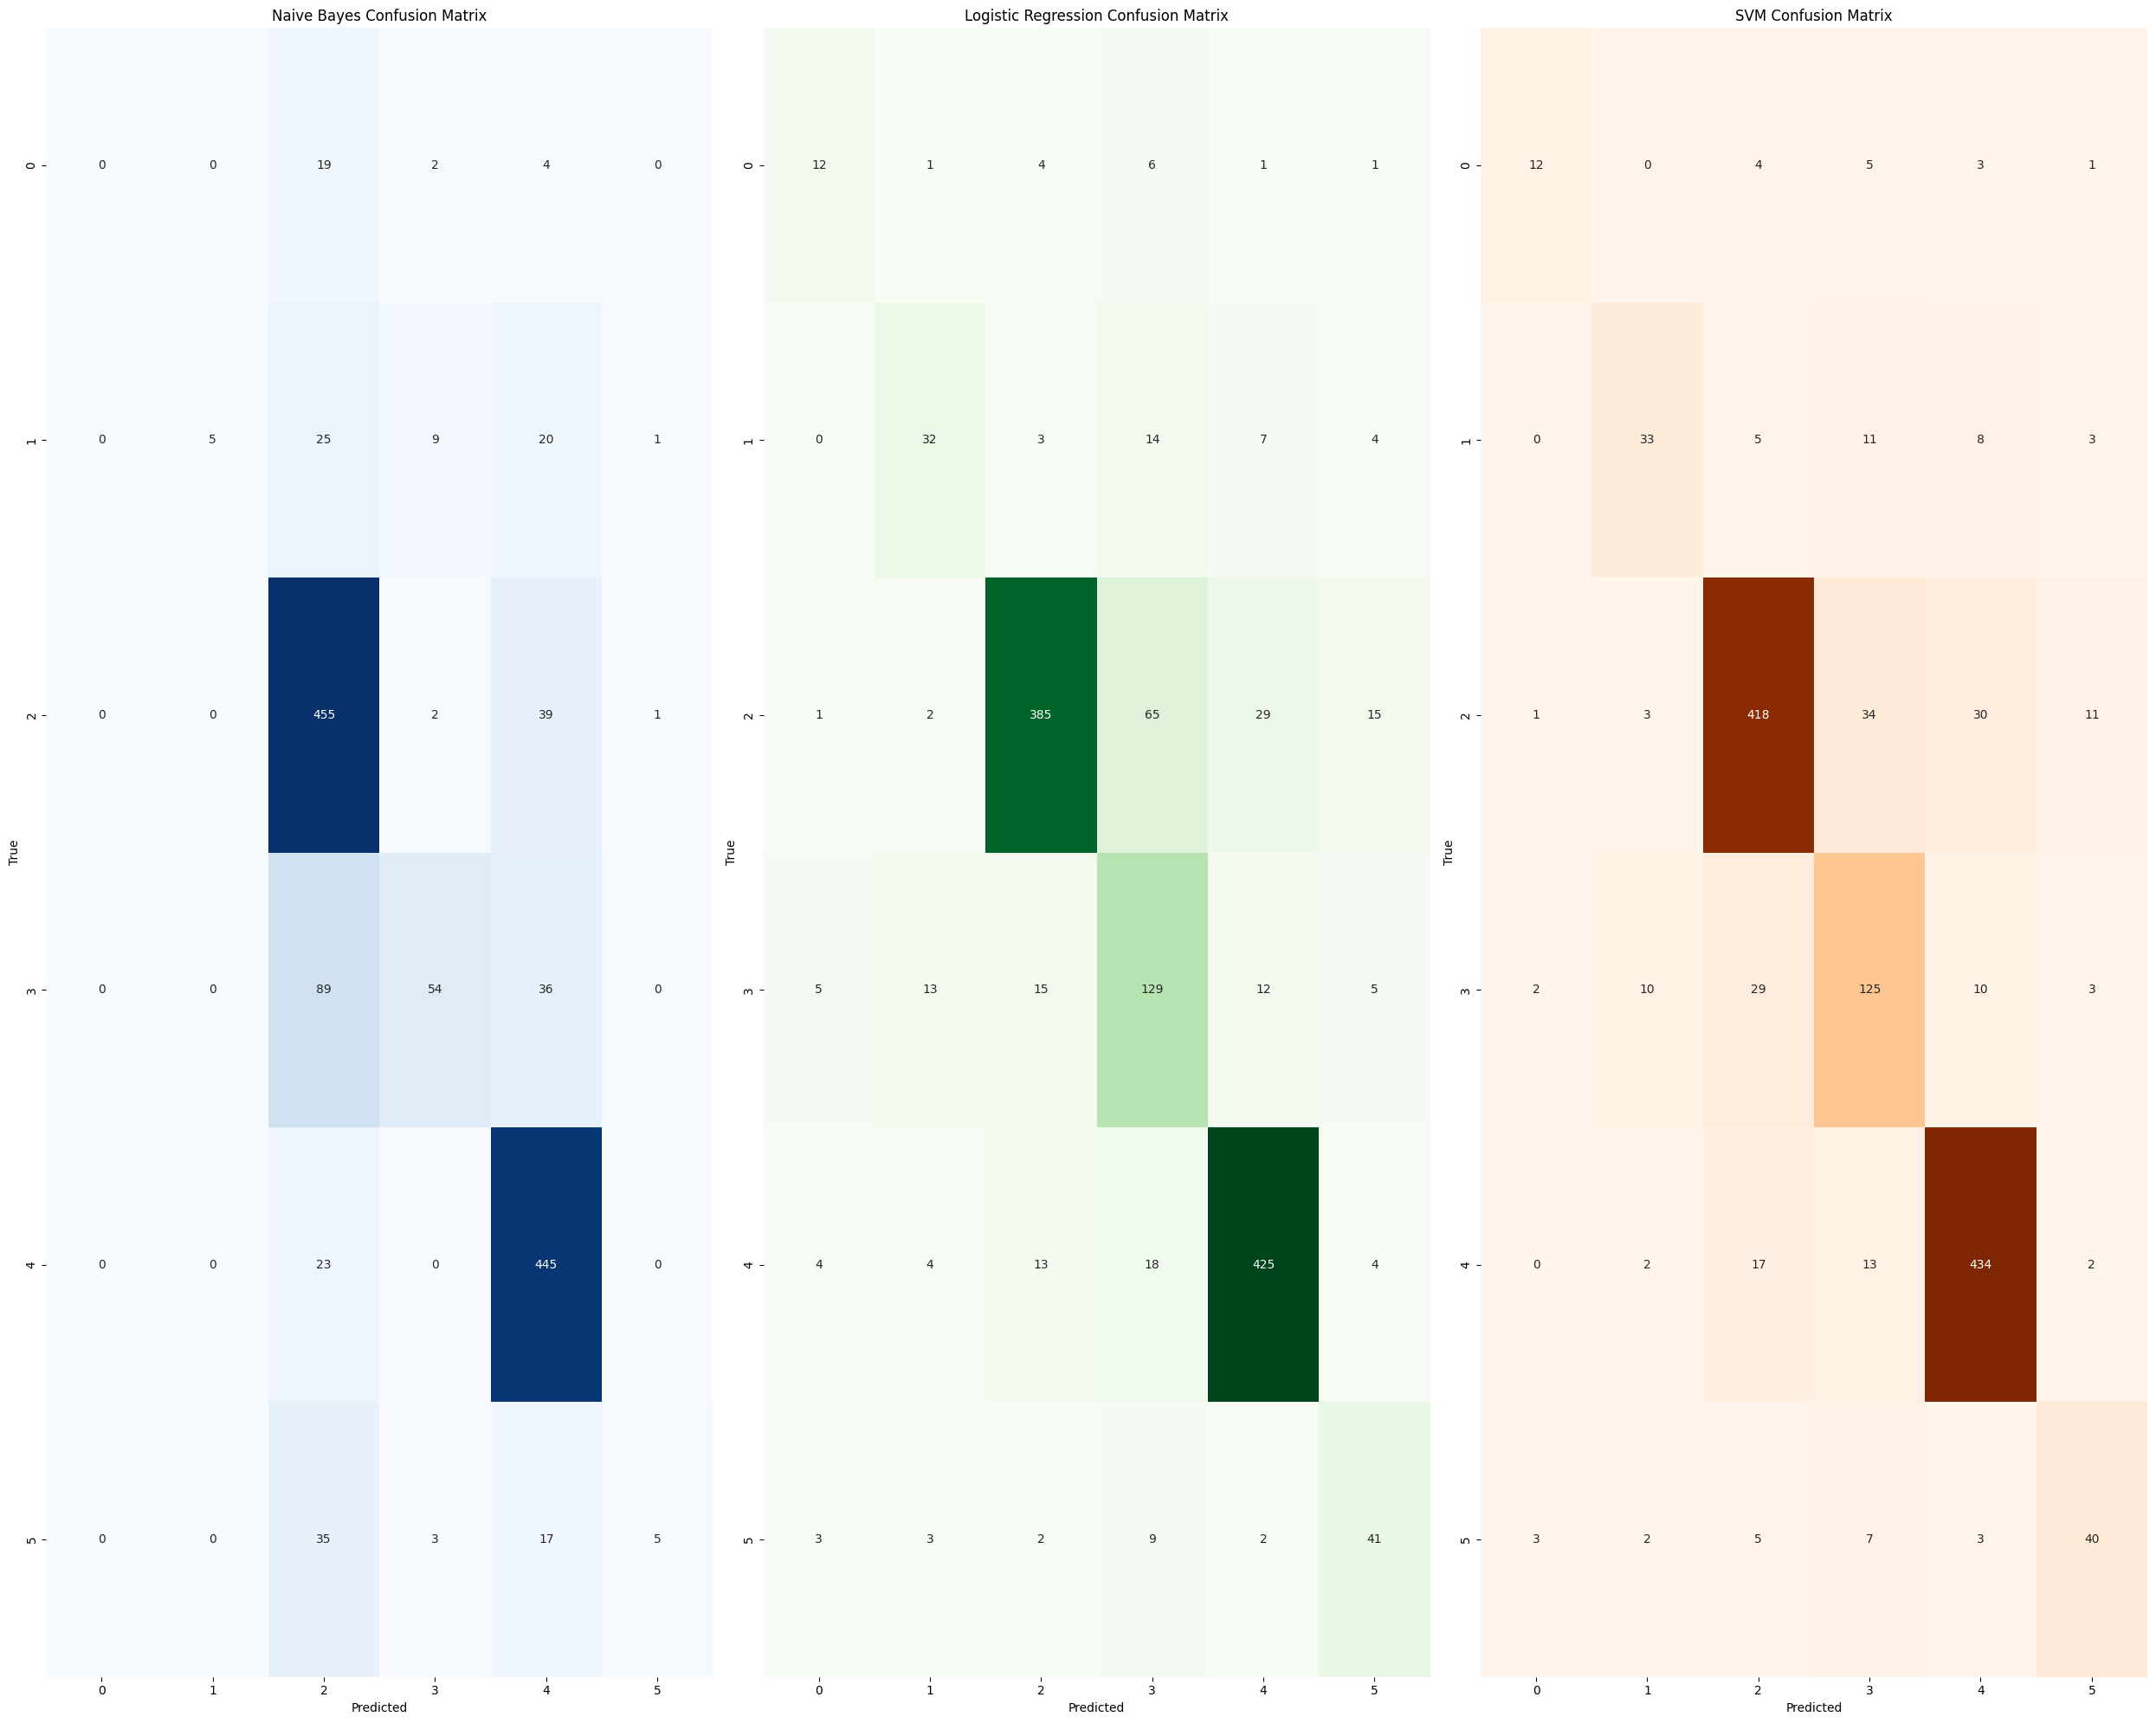

In [124]:
# === Confusion Matrices ===
nb_cm = confusion_matrix(y_test, nb_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

# === Plot Confusion Matrices ===
fig, axes = plt.subplots(1, 3, figsize=(25, 20))

sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Naive Bayes Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('SVM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()


In [125]:

# === Performance Summary Table ===
models_summary = {
    'Baseline': baseline_preds,
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions,
    'SVM': svm_predictions
}


print("\nModel Performance Summary:\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1"))
for name, preds in models_summary.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='macro')
    rec = recall_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')
    print("{:<20} {:.4f}    {:.4f}    {:.4f}    {:.4f}".format(name, acc, prec, rec, f1))


Model Performance Summary:

Model                Accuracy   Precision  Recall     F1        
Baseline             0.3856    0.0643    0.1667    0.0928
Naive Bayes          0.7479    0.6639    0.3891    0.3997
Logistic Regression  0.7944    0.6647    0.6834    0.6700
SVM                  0.8239    0.7330    0.6939    0.7098


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


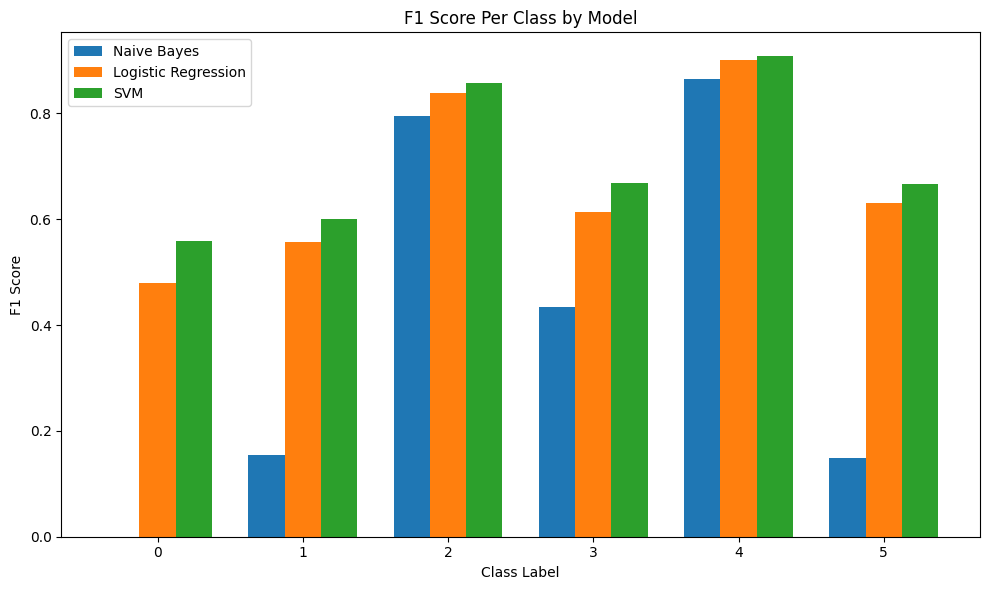

In [126]:
# === F1 Score Per Class ===
labels = sorted(np.unique(y_test))  # Auto-detect labels if unknown
nb_f1 = f1_score(y_test, nb_predictions, average=None, labels=labels)
lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, nb_f1, width, label='Naive Bayes')
plt.bar(x, lr_f1, width, label='Logistic Regression')
plt.bar(x + width, svm_f1, width, label='SVM')
plt.xlabel('Class Label')
plt.ylabel('F1 Score')
plt.title('F1 Score Per Class by Model')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
# Create a list of the original tweets corresponding to X_test
X_test_raw = data.loc[y_test.index, 'text'].values

# Create a DataFrame comparing true and predicted labels for all models

comparison_df = pd.DataFrame({
    'Tweet': X_test_raw,  # Raw tweet text
    'True Label': y_test,
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions,
    'SVM': svm_predictions
})

# Add a column to indicate if all models were wrong
comparison_df['All Wrong'] = (
    (comparison_df['Naive Bayes'] != comparison_df['True Label']) &
    (comparison_df['Logistic Regression'] != comparison_df['True Label']) &
    (comparison_df['SVM'] != comparison_df['True Label'])
)

# Filter only misclassified samples by any model
misclassified = comparison_df[
    (comparison_df['Naive Bayes'] != comparison_df['True Label']) |
    (comparison_df['Logistic Regression'] != comparison_df['True Label']) |
    (comparison_df['SVM'] != comparison_df['True Label'])
]

# Show top 10 misclassified samples
print("\n=== Misclassified Examples by Any Model ===")
print(misclassified.head(10))




=== Misclassified Examples by Any Model ===
                                                  Tweet  True Label  \
4622  Had to run to {@Micro Center@} to stock up on ...           3   
233   The climate change hoax - Dr. Tim Ball {{URL}}...           2   
6003  The blues are back  And so am I havent done a ...           4   
6126  Archive: Many media pundits, as witnessed by a...           3   
5907  ‘I was glad they had pop at me’   As we begin ...           4   
4094  Trying to put the water back and hope the heat...           3   
1872  Ahh can’t wait to use my annual pass at Galaxy...           2   
1297  I make money by delivering with {@Uber Eats@} ...           1   
156   Join us LIVE from day 2 of #LAB19 with {@SERA ...           2   
2087  Still waiting for {{USERNAME}} and my other fr...           4   

      Naive Bayes  Logistic Regression  SVM  All Wrong  
4622            4                    1    1       True  
233             2                    5    5      False  
60

In [128]:
# === Training Time Comparison ===
start_time = time.time()
MultinomialNB().fit(X_train, y_train)
nb_train_time = time.time() - start_time

start_time = time.time()
LogisticRegression(max_iter=200, class_weight='balanced').fit(X_train, y_train)
lr_train_time = time.time() - start_time

start_time = time.time()
LinearSVC(class_weight='balanced').fit(X_train, y_train)
svm_train_time = time.time() - start_time

print("\n=== Training Time (Seconds) ===")
print("{:<25} {:.4f}".format("Naive Bayes", nb_train_time))
print("{:<25} {:.4f}".format("Logistic Regression", lr_train_time))
print("{:<25} {:.4f}".format("SVM", svm_train_time))


=== Training Time (Seconds) ===
Naive Bayes               0.0071
Logistic Regression       2.0727
SVM                       0.2053


In [129]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha (Laplace smoothing)
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

# Create base model
nb_base = MultinomialNB()

# Grid search
nb_grid = GridSearchCV(estimator=nb_base, param_grid=nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train, y_train)

# Best model and predictions
tuned_nb_model = nb_grid.best_estimator_
tuned_nb_preds = tuned_nb_model.predict(X_test)
tuned_nb_acc = accuracy_score(y_test, tuned_nb_preds)

print(f"Tuned Naive Bayes Accuracy: {tuned_nb_acc:.4f}")
print("Tuned Naive Bayes Classification Report:")
print(classification_report(y_test, tuned_nb_preds))


Tuned Naive Bayes Accuracy: 0.8076
Tuned Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        25
           1       0.82      0.47      0.60        60
           2       0.85      0.85      0.85       497
           3       0.61      0.60      0.61       179
           4       0.84      0.94      0.89       468
           5       0.75      0.60      0.67        60

    accuracy                           0.81      1289
   macro avg       0.81      0.61      0.66      1289
weighted avg       0.81      0.81      0.80      1289



In [130]:
# === Save Trained Models ===
trained_models = {
    'NaiveBayes': nb_model,
    'LogisticRegression': lr_model,
    'SVM': svm_model
}

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Now save the models
joblib.dump(trained_models, 'models/trained_models.pkl')
print("Models saved to 'models/trained_models.pkl'")

Models saved to 'models/trained_models.pkl'
